# Gesture Recognition
In this group project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Importing the following libraries to get started.

In [1]:
import numpy as np
import os
# from scipy.misc import imresize
from skimage.transform import resize
from imageio import imread
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('C:/Users/HP/Desktop/Gesture Recognition/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('C:/Users/HP/Desktop/Gesture Recognition/Project_data/val.csv').readlines())
batch_size = 45

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #create a list of image numbers you want to use for a particular video
    img_idx = [11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(source_path)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = image.resize(100, 100)
                    
                    batch_data[folder,idx,:,:,0] = 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if((len(source_path)%batch_size)//2==0):
            batch_size = 2
        else:
            batch_size = 1
        num_batches = len(source_path)%batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,18,100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    
                    
                    # Cropped image of above dimension 
                    # (It will not change orginal image) 
                    
                    #image = image.crop((0, 0, 120, 120))
                    image = image.resize(100, 100)
                    
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] /= 255
                    batch_data[folder,idx,:,:,1] /= 255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] /= 255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'C:/Users/HP/Desktop/Gesture Recognition/Project_data/train'
val_path = 'C:/Users/HP/Desktop/Gesture Recognition/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#write your model here
Input_shape = (18, 100, 100, 3)
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [7]:
from tensorflow import keras
optimiser = keras.optimizers.Adam(lr=0.001)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 18, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 18, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 98, 98, 32)    27680     
                                                                 
 activation_1 (Activation)   (None, 16, 98, 98, 32)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 98, 98, 32)   128       
 hNormalization)                                        

C:\Users\HP\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [8]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [9]:
model_name = 'gesture_recognition' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 10,
  verbose = 0, mode = "auto", epsilon = 1e-04, cooldown = 0,
  min_lr = 0)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [10]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [11]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\HP\AppData\Local\Temp/ipykernel_23176/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  C:/Users/HP/Desktop/Gesture Recognition/Project_data/train ; batch size = 45
Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 33.2849 - categorical_accuracy: 0.2034Source path =  C:/Users/HP/Desktop/Gesture Recognition/Project_data/val ; batch size = 45

Epoch 1: saving model to gesture_recognition_2022-09-1508_08_12.500140\model-00001-33.28488-0.20339-6071.03467-0.19149.h5
15/15 [==============================] - 104s 2s/step - loss: 33.2849 - categorical_accuracy: 0.2034 - val_loss: 6071.0347 - val_categorical_accuracy: 0.1915 - lr: 0.0010
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 22.2048 - categorical_accuracy: 0.4667
Epoch 2: saving model to gesture_recognition_2022-09-1508_08_12.500140\model-00002-22.20480-0.46667-5341.96924-0.00000.h5
15/15 [==============================] - 28s 2s/step - loss: 22.2048 - categorical_accuracy: 0.4667 - val_loss: 5341.9692 - val_categorical_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/20
15/1

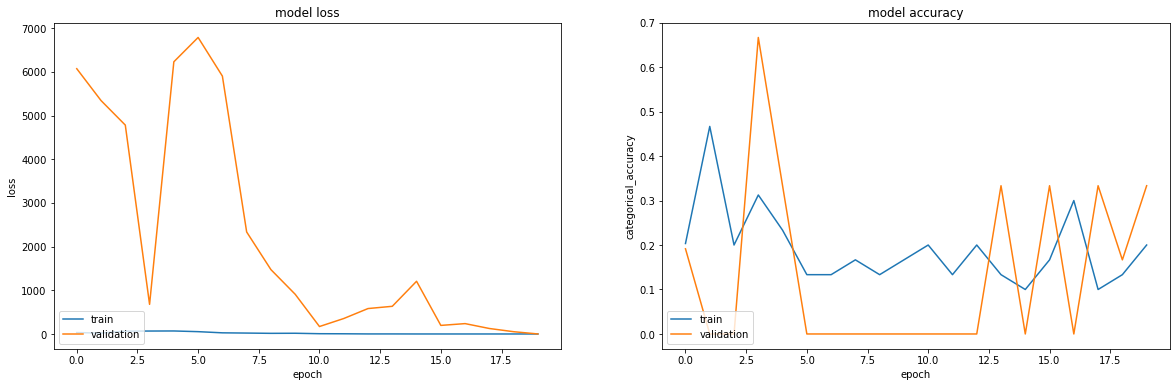

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')